# <font color='008fd0'>Overview</font>

This notebooks represents the final improvements of the Hospital Model, with an orchestrated pipeline and hyperparameter tuning.

## <font color='00b269'>Workflow</font>
- **Exploratory Data Analysis**: 
   - City Boxplots
   - Correlation Matrix - Dependencies between Features
- **Pipeline**:
   - DateTransformer - Augment Dataset:
      - Day - day of week / weekend
      - Month
      - Holiday
   - CityTransformer - Augment Dataset:
      - Categorical Encoding
      - Population
      - Geolocation
   - Basic Experiments:
      - Use Mean Temperature instead of Min-Max
      - Numerical Scaling
- **Model**:
   - HyperParameter Tuning - Exploration:
      - Processing Parameters
      - XGBoost HyperParameters
   - Optimized Model
- **Evaluate Model**:
   - Absolute Error Distribution
   - Regressor - Weight & Gain
   - Groundtruth vs Predicted Scatter
   - Residual Plot
   - Residual Distribution
   - Actual vs Predicted Distribution


In [50]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import holidays
from workalendar.europe import Romania
from sklearn.base import TransformerMixin
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import pickle


In [51]:
dataset = pd.read_csv('../../../Data/Hospital/Hospital.csv')
dataset.head()

,Date,City,Patients,Max,Min,Prec,Press,Wind,Insolat
0,2007-01-29,Bucuresti,472,10.6,-1.0,0.2,1003.8,22,7.9
1,2007-10-22,Bucuresti,503,12.2,4.6,9.7,1012.5,22,0.3
2,2007-01-03,Constanta,76,9.8,1.7,4.3,1006.3,24,0.9
3,2007-01-29,Constanta,71,9.8,-0.5,0.6,1003.8,23,5.2
4,2007-02-23,Constanta,94,1.9,-3.9,1.0,1016.7,20,0.4


In [52]:
dataset.drop(columns=['City', 'Date']).corr().round(2)['Patients'].sort_values(ascending=False).reset_index()


,index,Patients
0,Patients,1.00
1,Max,0.06
2,Prec,0.01
3,Insolat,0.01
4,Wind,0.00
5,Press,-0.02
6,Min,-0.06


Features vs Target Correlation: 0.16


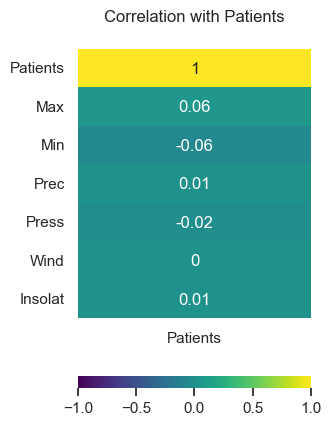

In [53]:
## correlation matrix to see the correlation between the variables
corr = dataset.drop(columns=['City', 'Date']).corr().round(2)

# Select only the 'Patients' column
corr_patients = corr[['Patients']]

print(f"Features vs Target Correlation: {corr['Patients'].abs().sum() - 1:.2f}")

plt.figure(figsize=(3,5))
sns.heatmap(corr_patients, annot=True, cmap='viridis', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlation with Patients', pad=20)
plt.show()

Features vs Target Correlation: 0.16


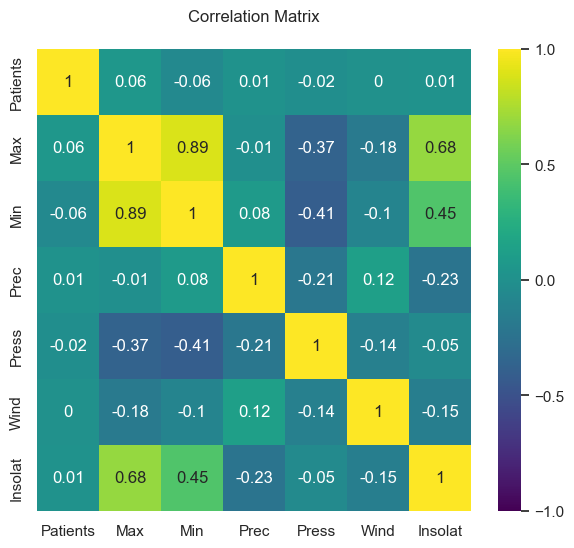

In [54]:
## correlation matrix to see the correlation between the variables
corr = dataset.drop(columns=['City', 'Date']).corr().round(2)

print(f"Features vs Target Correlation: {corr['Patients'].abs().sum() - 1:.2f}")

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap='viridis', vmin=-1, vmax=1, cbar_kws={"ticks":[-1, -0.5, 0, 0.5, 1]})
plt.title('Correlation Matrix', pad=20)
plt.show()

## EDA

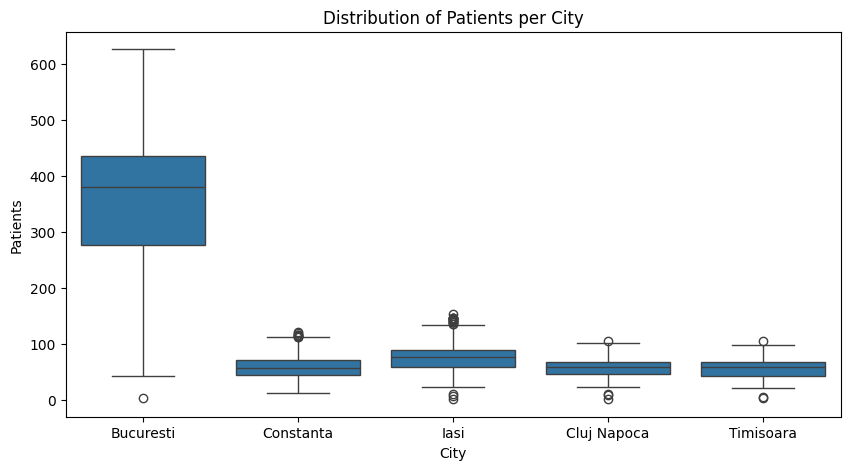

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(x='City', y='Patients', data=dataset)
plt.title("Distribution of Patients per City")
plt.xlabel("City")
plt.ylabel("Patients")
plt.show()

## Pipeline

In [55]:
class DateTransformer(TransformerMixin):
    def __init__(self, day='dayofweek', month=False, holiday=False):
        self.day = day
        self.month = month
        self.holiday = holiday

    def fit(self, X, y=None):
        return self

    def transform(self, df):
        X = df.copy()
        X['Date'] = pd.to_datetime(X['Date']).dt.date

        if self.day == 'dayofweek':
            X['Day'] = X['Date'].apply(lambda x: x.weekday())
        elif self.day == 'weekend':
            X['Weekend'] = X['Date'].apply(lambda x: 1 if x.weekday() >= 4 else 0)
        if self.month:
            X['Month'] = X['Date'].apply(lambda x: x.month)
        if self.holiday:
            min_year = X['Date'].min().year
            max_year = X['Date'].max().year
            holiday = list(holidays.Romania(years=range(min_year, max_year + 1)).keys())
            holiday += [date + pd.Timedelta(days=2) for date in holiday] + [date - pd.Timedelta(days=2) for date in holiday]
            X['Holiday'] = X['Date'].apply(lambda x: 1 if x in holiday else 0)

        X.drop(columns=['Date'], inplace=True)
        return X
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [56]:
geolocator = Nominatim(user_agent="hospital")
def get_coordinates(city):
        location = geolocator.geocode(city)
        if location:
            return round(location.latitude, 2), round(location.longitude, 2)
        else:
            return None, None

cities = dataset['City'].unique()
city_coordinates = {}
for city in cities:
    city_coordinates[city] = get_coordinates(city)
city_coordinates

{'Bucuresti': (44.44, 26.1),
 'Constanta': (44.17, 28.62),
 'Iasi': (47.16, 27.58),
 'Cluj Napoca': (46.77, 23.59),
 'Timisoara': (45.75, 21.23)}

In [57]:
class CityTransformer(TransformerMixin):
    def __init__(self, encoding='ohe', population=False, coordinates=False):
        self.encoding = encoding
        self.population = population
        self.coordinates = coordinates
        self.populations = {
            'Cluj Napoca': 322_108,
            'Timisoara': 333_613,
            'Iasi': 357_192,
            'Constanta': 319_168,
            'Bucuresti': 2_103_346,
        }
        self.city_coordinates = {
            'Bucuresti': (44.44, 26.1),
            'Constanta': (44.17, 28.62),
            'Iasi': (47.16, 27.58),
            'Cluj Napoca': (46.77, 23.59),
            'Timisoara': (45.75, 21.23)
        }
    
    def fit(self, X, y=None):
        if self.encoding == 'le':
            self.city_encoder = LabelEncoder() 
            self.city_encoder.fit(X['City'])
        elif self.encoding == 'ohe':
            self.city_encoder = OneHotEncoder(sparse_output=False, dtype=np.int64)
            self.city_encoder.fit(X[['City']])
        return self

    def transform(self, X):     
        if self.population:
            X['Population'] = X['City'].apply(lambda x: self.populations[x] if x in self.populations else None)
        if self.coordinates:
            X['Latitude'], X['Longitude'] = zip(*X['City'].apply(lambda x: self.city_coordinates[x]))

        if self.encoding == 'ohe':
            categ = self.city_encoder.get_feature_names_out()
            X[categ] = self.city_encoder.transform(X[['City']])
            X.drop(columns=['City'], inplace=True)
        elif self.encoding == 'le':
            X['City'] = self.city_encoder.transform(X['City'])
        else:
            X.drop(columns=['City'], inplace=True)
        return X
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [58]:
pipeline = Pipeline([
    ('DateTransformer', DateTransformer()),
    ('CityTransformer', CityTransformer()),
    ('Model', XGBRegressor()) 
])

In [60]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=['Patients'])
y = dataset['Patients']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=dataset['City'], shuffle=True)

## Cross Validation - Data Transformations

In [37]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

param_grid = {
    'DateTransformer__day': ['dayofweek', 'weekend'],
    'DateTransformer__month': [True, False],
    'DateTransformer__holiday': [True, False],
    'CityTransformer__encoding': ['ohe', 'le'],
    'CityTransformer__population': [True, False],
    'CityTransformer__coordinates': [True, False]
}

search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DateTransformer',
                                        <__main__.DateTransformer object at 0x7fa840f20e50>),
                                       ('CityTransformer',
                                        <__main__.CityTransformer object at 0x7fa840f23d30>),
                                       ('Model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=N...
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'CityTransformer__coordinates': [True, False],
                         'CityTransformer__encoding': ['ohe', 'le'],
                         'CityTransformer__population': [True, False],
                         'DateTransformer__day': ['dayofweek', 'weekend'],
                         'DateTransformer__holiday': [True, False],
                         'DateTransformer__month': [True, False]},
             scoring='neg_mean_absolute_error', verbose=1)

In [38]:
from sklearn.metrics import mean_absolute_error

y_pred = search.predict(X_test)
mean_absolute_error(y_test, y_pred).round(2)

15.62

In [39]:
scores = -search.cv_results_['mean_test_score'].round(2)
params = search.cv_results_['params']

results = pd.DataFrame(params)
results.columns = results.columns.str.split('__').str[-1]
results['MAE'] = scores
results.set_index('MAE', inplace=True)
results.sort_index(inplace=True)

results

,coordinates,encoding,population,day,holiday,month
MAE,,,,,,
15.71,True,le,False,dayofweek,True,True
15.74,False,ohe,False,dayofweek,True,True
15.76,False,le,False,dayofweek,True,True
15.79,True,le,True,dayofweek,True,True
15.80,True,ohe,True,dayofweek,True,True
...,...,...,...,...,...,...
21.93,False,le,True,weekend,False,False
21.95,False,le,False,weekend,False,False
21.97,True,ohe,False,weekend,False,False


In [ ]:
results = pd.read_csv('../Data/HospitalExperimentsProcessing.csv')
results.head(10)

,MAE,avg,scaler,coordinates,encoding,population,day,holiday,month
0,16.36,False,False,False,ohe,True,dayofweek,True,True
1,16.39,False,False,True,le,False,dayofweek,True,True
2,16.39,False,False,False,le,True,dayofweek,True,True
3,16.40,True,False,True,le,False,dayofweek,True,True
4,16.40,True,False,False,le,False,dayofweek,True,True
5,16.41,True,False,False,le,True,dayofweek,True,True
6,16.43,False,False,True,le,True,dayofweek,True,True
7,16.44,True,False,False,ohe,True,dayofweek,True,True
8,16.44,False,False,False,le,False,dayofweek,True,True
9,16.45,True,False,True,le,True,dayofweek,True,True


[('avg', False) ('coordinates', True) ('day', 'dayofweek')
 ('encoding', 'le') ('holiday', True) ('month', True) ('population', True)
 ('scaler', False)]


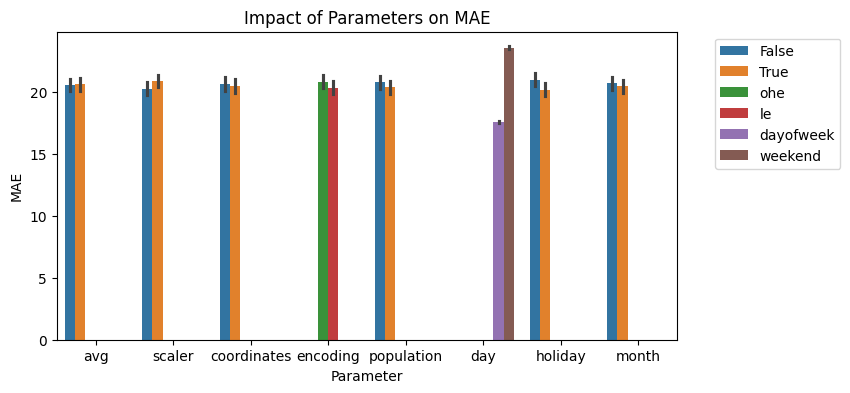

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

params = results.columns.drop('MAE').to_list()
pivot_table = pd.melt(results, id_vars=['MAE'], value_vars=params, var_name='param', value_name='param_value')

best_params_indices = pivot_table.groupby(['param', 'param_value'])['MAE'].mean().groupby('param').idxmin().values
print(best_params_indices)

plt.figure(figsize=(8, 4))
sns.barplot(x='param', y='MAE', hue='param_value', data=pivot_table)
plt.title("Impact of Parameters on MAE")
plt.xlabel("Parameter")
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Cross Validation - XGBoost

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

pipeline = Pipeline([
    ('DateTransformer', DateTransformer(
        day= 'dayofweek',
        holiday= True,
        month = True
    )),
    ('CityTransformer', CityTransformer(
        encoding='le',
        coordinates= True,
        population= True
    )),
    ('Model', XGBRegressor()) 
])

param_grid = {
    'Model__learning_rate': [0.005, 0.01, 0.05, 0.1],    
    'Model__n_estimators': [50, 100, 150],
    'Model__max_depth': [3, 5, 7],
    'Model__min_child_weight': [1, 3, 5]
}

search = GridSearchCV(pipeline, param_grid, cv=4, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('DateTransformer',
                                        <__main__.DateTransformer object at 0x7fa830b38160>),
                                       ('CityTransformer',
                                        <__main__.CityTransformer object at 0x7fa830b38580>),
                                       ('Model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=N...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Model__learning_rate': [0.005, 0.01, 0.05, 0.1],
                         'Model__max_depth': [3, 5, 7],
                         'Model__min_child_weight': [1, 3, 5],
                         'Model__n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_error', verbose=1)

In [41]:
from sklearn.metrics import mean_absolute_error

y_pred = search.predict(X_test)
mean_absolute_error(y_test, y_pred).round(2) 

14.97

In [42]:
scores = -search.cv_results_['mean_test_score'].round(2)
params = search.cv_results_['params']

results = pd.DataFrame(params)
results.columns = results.columns.str.split('__').str[-1]
results['MAE'] = scores
results.sort_values(by=['MAE'], inplace=True)

results

,learning_rate,max_depth,min_child_weight,n_estimators,MAE
65,0.050,5,1,150,14.93
71,0.050,5,5,150,14.94
68,0.050,5,3,150,14.95
70,0.050,5,5,100,14.97
90,0.100,5,1,50,14.97
...,...,...,...,...,...
15,0.005,5,5,50,85.23
6,0.005,3,5,50,85.23
24,0.005,7,5,50,85.26
18,0.005,7,1,50,85.28


[('learning_rate', 0.1) ('max_depth', 5.0) ('min_child_weight', 5.0)
 ('n_estimators', 150.0)]


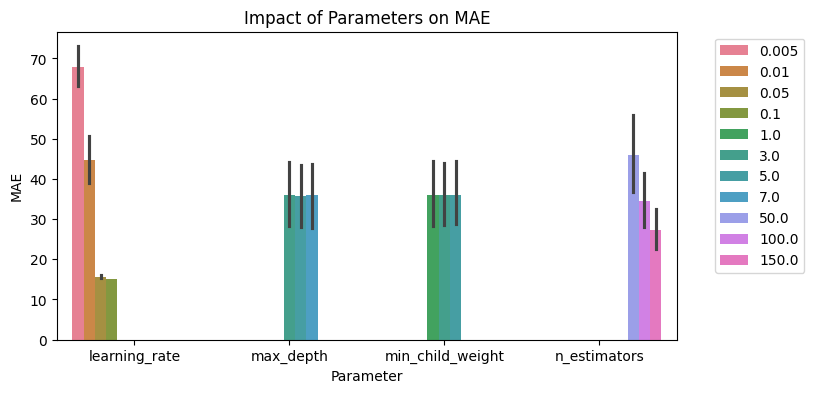

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params = results.columns.drop('MAE').to_list()
pivot_table = pd.melt(results, id_vars=['MAE'], value_vars=params, var_name='param', value_name='param_value')

best_params = pivot_table.groupby(['param', 'param_value'])['MAE'].mean().groupby('param').idxmin().values
print(best_params)
plt.figure(figsize=(8, 4))

palette = sns.color_palette("husl", n_colors=len(pivot_table['param_value'].unique()))

sns.barplot(x='param', y='MAE', hue='param_value', data=pivot_table, palette=palette)
plt.title("Impact of Parameters on MAE")
plt.xlabel("Parameter")
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Final Pipeline

In [64]:
model = Pipeline([
    ('DateTransformer', DateTransformer(
        day= 'dayofweek',
        holiday= True,
        month = True
    )),
    ('CityTransformer', CityTransformer(
        encoding=None,
        coordinates= True,
        population= True
    )),
    ('Model', XGBRegressor(
        learning_rate=0.1, 
        max_depth=5, 
        n_estimators=150, 
        min_child_weight=5
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('DateTransformer',
                 <__main__.DateTransformer object at 0x7fa8410180a0>),
                ('CityTransformer',
                 <__main__.CityTransformer object at 0x7fa84101b640>),
                ('Model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=150,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [65]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
print(f"Test MAE: {mae}")

Test MAE: 15.0


In [66]:
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred).round(2)
print(f"Train MAE: {mae}")

Train MAE: 12.95


In [67]:
with open('../../Models/Hospital.pkl', 'wb') as file:
    pickle.dump(model, file)

## Final results

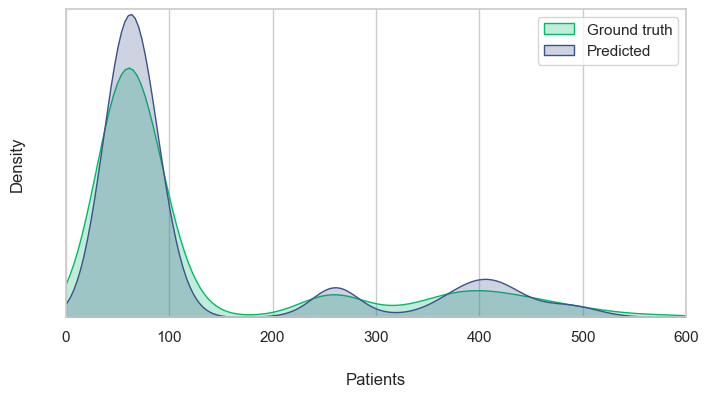

In [47]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.kdeplot(y_test, color='#00bb68', label='Ground truth', fill=True)
sns.kdeplot(y_pred, color='#3c518b', label='Predicted', fill=True)
# plt.title("Ground truth vs Predicted Distribution", pad=20)
plt.xlim(0, 600)
plt.ylim(0, 0.012)
plt.yticks([0, 0.005, 0.01], [])
plt.gca().yaxis.grid(False)  # Remove grid lines
plt.ylabel("Density", labelpad=20)
plt.xlabel("Patients", labelpad=20)
plt.legend()
plt.show()

Iasi: 8.68 -> 11.55%
Constanta: 11.08 -> 18.73%
Bucuresti: 27.64 -> 7.46%
Cluj Napoca: 6.48 -> 11.24%
Timisoara: 6.33 -> 11.28%


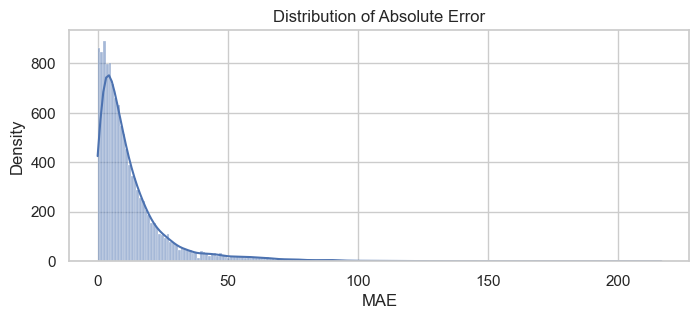

Total: 12.95 -> 9.66%


In [48]:
y_pred = model.predict(X_train)
absolute_error = np.abs(y_train - y_pred).round(2)
for city in X_train['City'].unique():
    idx = X_train['City'] == city
    avg = y_train[idx].mean()
    mae = absolute_error[idx].mean()
    print(f"{city}: {mae:.2f} -> {mae/avg*100:.2f}%")

plt.figure(figsize=(8,3))
sns.histplot(absolute_error, kde=True)
plt.title("Distribution of Absolute Error")
plt.xlabel("MAE")
plt.ylabel("Density")
plt.show()
print(f"Total: {absolute_error.mean():.2f} -> {absolute_error.mean()/y_test.mean()*100:.2f}%")


Bucuresti: 34.00 -> 9.21%
Constanta: 11.77 -> 19.81%
Iasi: 9.85 -> 13.09%
Cluj Napoca: 6.93 -> 12.12%
Timisoara: 7.03 -> 12.53%


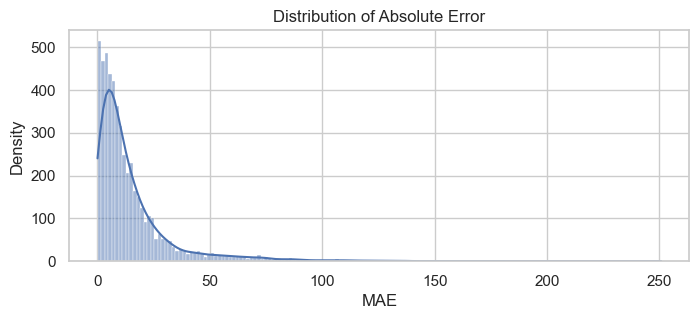

Total: 15.00 -> 11.19%


In [49]:
y_pred = model.predict(X_test)
absolute_error = np.abs(y_test - y_pred).round(2)
for city in X_test['City'].unique():
    idx = X_test['City'] == city
    avg = y_test[idx].mean()
    mae = absolute_error[idx].mean()
    print(f"{city}: {mae:.2f} -> {mae/avg*100:.2f}%")

plt.figure(figsize=(8,3))
sns.histplot(absolute_error, kde=True)
plt.title("Distribution of Absolute Error")
plt.xlabel("MAE")
plt.ylabel("Density")
plt.show()
print(f"Total: {absolute_error.mean():.2f} -> {absolute_error.mean()/y_test.mean()*100:.2f}%")


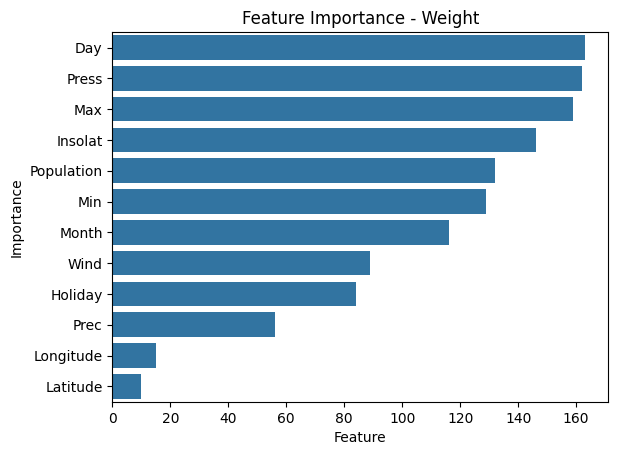

In [97]:
importances = model['Model'].get_booster().get_score(importance_type='weight')
importances = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
importances.sort_values(by=['importance'], ascending=False, inplace=True)
sns.barplot(y=importances.index, x='importance', data=importances, orient='h')
plt.title("Feature Importance - Weight")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

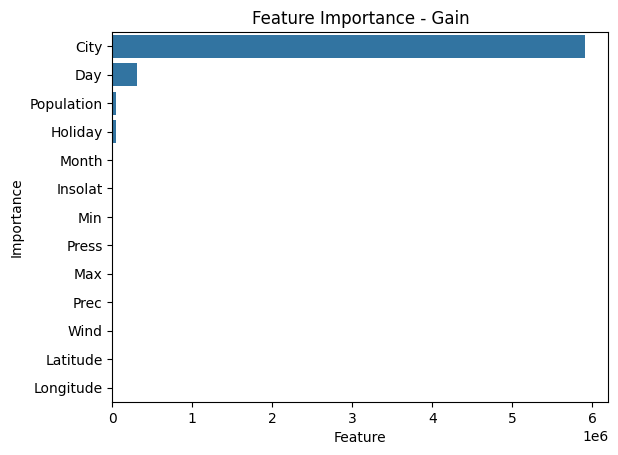

In [403]:
importances = model['Model'].get_booster().get_score(importance_type='gain')
importances = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
importances.sort_values(by=['importance'], ascending=False, inplace=True)
sns.barplot(y=importances.index, x='importance', data=importances, orient='h')
plt.title("Feature Importance - Gain")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

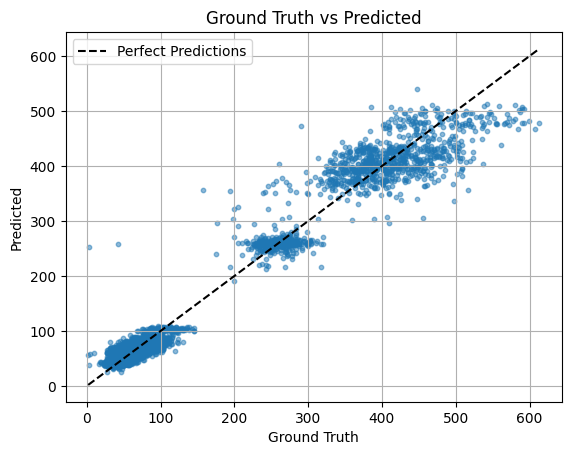

In [98]:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', label='Perfect Predictions')
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Ground Truth vs Predicted')
plt.legend()
plt.grid()
plt.show()

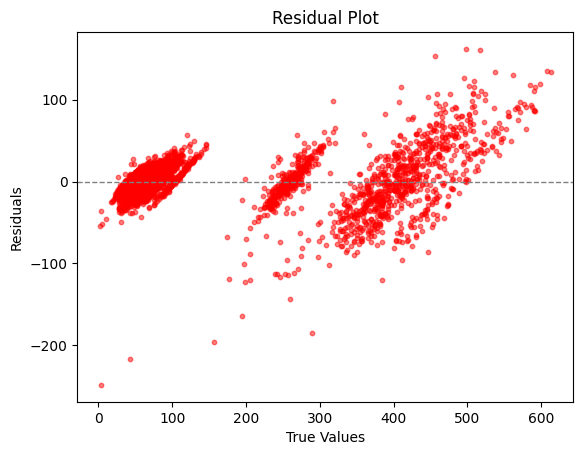

In [387]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5, color='red', s=10)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

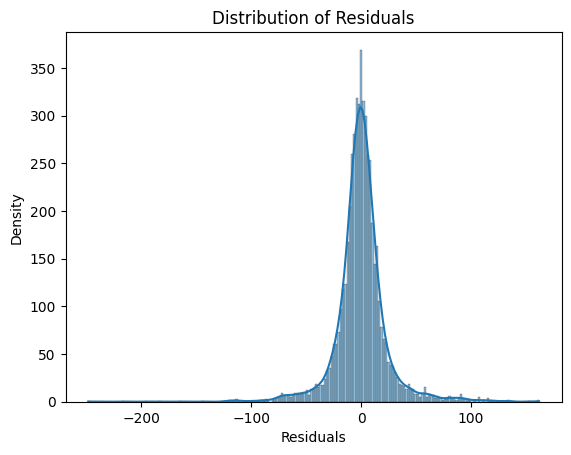

In [388]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()

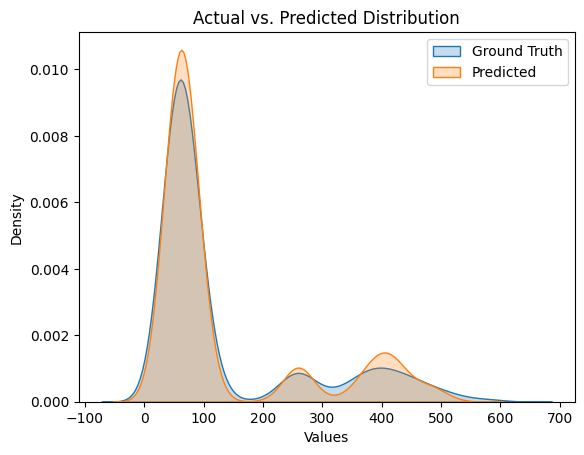

In [392]:
sns.kdeplot(y_test, label='Ground Truth', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Actual vs. Predicted Distribution')
plt.legend()
plt.show()